# TensorFlow Lite Model Performance Evaluation Report

---

### 📋 **Thông tin đồ án**
- **Project**: Hand Gesture Recognition for Car Control System
- **Model**: TensorFlow Lite Keypoint Classifier
- **Author**: Nhóm 5
- **Date**: July 2025
- **Version**: 1.0

### 🎯 **Mục Tiêu Đánh Giá**
1. **Đánh Giá Hiệu Suất**: Phân tích độ chính xác, precision, recall và F1-score của mô hình
2. **Kiểm Tra Tốc Độ**: Đo thời gian suy luận và khả năng hoạt động thời gian thực
3. **Phân Tích Ma Trận Nhầm Lẫn**: Xác định các mẫu phân loại sai và nguồn gốc lỗi
4. **Sẵn Sàng Sản Xuất**: Đánh giá tính phù hợp của mô hình cho ứng dụng điều khiển xe thời gian thực

### 🚗 **Bối Cảnh Ứng Dụng**
Mô hình TensorFlow Lite này được thiết kế để nhận dạng cử chỉ tay thời gian thực trong hệ thống điều khiển xe tự hành. Mô hình xử lý các điểm mốc bàn tay từ MediaPipe để phân loại cử chỉ người lái thành các lệnh di chuyển: Tiến, Lùi, Trái, Phải và Dừng, với khả năng phát hiện cử chỉ không xác định để đảm bảo an toàn.

### 📊 **Phương Pháp Đánh Giá**
- **Bộ Dữ Liệu Kiểm Tra**: Chia 25% từ dữ liệu huấn luyện ban đầu
- **Chỉ Số**: Phân tích toàn diện độ chính xác, precision, recall, F1-score
- **Kiểm Tra Tốc Độ**: Hơn 200 lần chạy suy luận với phân tích thống kê
- **Phân Tích Độ Tin Cậy**: Phát hiện độ không chắc chắn dựa trên ngưỡng
- **Xác Thực Thời Gian Thực**: Đánh giá khả năng FPS cho triển khai sản xuất

---

## 1. Import Required Libraries

Import all necessary libraries for model evaluation, data processing, and visualization.

In [26]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='requests')
warnings.filterwarnings('ignore', module='h5py')

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Configure matplotlib for notebook display
import matplotlib
try:
    # Try to use widget backend for interactive plots
    matplotlib.use('module://ipykernel.pylab.backend_inline')
except:
    # Fall back to default
    matplotlib.use('inline')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

TensorFlow version: 2.10.0


## 2. Load and Prepare Test Dataset

Load the keypoint dataset and prepare test data for model evaluation.

In [27]:
# Define paths
dataset_path = 'model/keypoint_classifier/keypoint.csv'
tflite_model_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
labels_path = 'model/keypoint_classifier/keypoint_classifier_label.csv'

# Define number of classes and feature dimensions
NUM_CLASSES = 6  # Updated to include Unknown gesture
NUM_FEATURES = 21 * 2  # 21 hand landmarks × 2 coordinates

# Load gesture labels
gesture_labels = []
try:
    with open(labels_path, 'r', encoding='utf-8-sig') as f:
        gesture_labels = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(gesture_labels)} gesture labels:")
    for i, label in enumerate(gesture_labels):
        print(f"  {i}: {label}")
except FileNotFoundError:
    print(f"Labels file not found: {labels_path}")
    gesture_labels = ['Forward', 'Back', 'Left', 'Right', 'Stop', 'Unknown']
    print("Using default labels:", gesture_labels)

# Load dataset
print(f"\nLoading dataset from: {dataset_path}")
try:
    # Load features (columns 1-42: hand keypoint coordinates)
    X_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='float32', 
                          usecols=list(range(1, NUM_FEATURES + 1)))
    
    # Load labels (column 0: gesture class)
    y_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))
    
    print(f"Dataset shape: {X_dataset.shape}")
    print(f"Labels shape: {y_dataset.shape}")
    print(f"Unique classes: {np.unique(y_dataset)}")
    
    # Split data into train and test sets (same split as training)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED
    )
    
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Test set distribution:")
    unique, counts = np.unique(y_test, return_counts=True)
    for class_id, count in zip(unique, counts):
        if class_id < len(gesture_labels):
            print(f"  {gesture_labels[class_id]}: {count} samples")
        else:
            print(f"  Class {class_id}: {count} samples")
            
except FileNotFoundError:
    print(f"Dataset file not found: {dataset_path}")
    X_test, y_test = None, None

Loaded 6 gesture labels:
  0: Forward
  1: Back
  2: Left
  3: Right
  4: Stop
  5: Unknown

Loading dataset from: model/keypoint_classifier/keypoint.csv
Dataset shape: (1500, 42)
Labels shape: (1500,)
Unique classes: [0 1 2 3 4]
Test set size: 375 samples
Test set distribution:
  Forward: 68 samples
  Back: 62 samples
  Left: 84 samples
  Right: 85 samples
  Stop: 76 samples


## 3. Load TFLite Model

Initialize the TensorFlow Lite interpreter and load the quantized model.

In [28]:
# Load TFLite model
print(f"Loading TFLite model from: {tflite_model_path}")
try:
    # Initialize TensorFlow Lite interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print("✅ TFLite model loaded successfully!")
    print(f"Input details:")
    print(f"  Name: {input_details[0]['name']}")
    print(f"  Shape: {input_details[0]['shape']}")
    print(f"  Type: {input_details[0]['dtype']}")
    
    print(f"Output details:")
    print(f"  Name: {output_details[0]['name']}")
    print(f"  Shape: {output_details[0]['shape']}")
    print(f"  Type: {output_details[0]['dtype']}")
    
    # Verify model compatibility
    expected_input_shape = (1, NUM_FEATURES)
    actual_input_shape = tuple(input_details[0]['shape'])
    
    if actual_input_shape == expected_input_shape:
        print(f"✅ Model input shape matches expected: {expected_input_shape}")
    else:
        print(f"⚠️  Model input shape mismatch!")
        print(f"   Expected: {expected_input_shape}")
        print(f"   Actual: {actual_input_shape}")
        
except FileNotFoundError:
    print(f"❌ TFLite model file not found: {tflite_model_path}")
    interpreter = None
except Exception as e:
    print(f"❌ Error loading TFLite model: {e}")
    interpreter = None

Loading TFLite model from: model/keypoint_classifier/keypoint_classifier.tflite
✅ TFLite model loaded successfully!
Input details:
  Name: input_1
  Shape: [ 1 42]
  Type: <class 'numpy.float32'>
Output details:
  Name: Identity
  Shape: [1 5]
  Type: <class 'numpy.float32'>
✅ Model input shape matches expected: (1, 42)


## 4. Model Inference and Evaluation

Perform batch inference on the test dataset and collect prediction results.

In [29]:
# Perform batch inference on test data
def predict_tflite_batch(interpreter, X_batch):
    """
    Perform batch inference using TFLite interpreter
    Returns predictions and confidence scores
    """
    predictions = []
    confidences = []
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    for i, sample in enumerate(X_batch):
        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], 
                             np.array([sample], dtype=np.float32))
        
        # Run inference
        interpreter.invoke()
        
        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        prediction = np.squeeze(output_data)
        
        # Get predicted class and confidence
        predicted_class = np.argmax(prediction)
        confidence_score = prediction[predicted_class]
        
        predictions.append(predicted_class)
        confidences.append(confidence_score)
        
        # Progress indicator
        if (i + 1) % 50 == 0 or (i + 1) == len(X_batch):
            print(f"Processed {i + 1}/{len(X_batch)} samples", end='\r')
    
    print()  # New line after progress
    return np.array(predictions), np.array(confidences)

# Run inference if model and data are available
if interpreter is not None and X_test is not None:
    print("Running inference on test data...")
    start_time = time.time()
    
    y_pred, y_confidence = predict_tflite_batch(interpreter, X_test)
    
    inference_time = time.time() - start_time
    print(f"✅ Inference completed!")
    print(f"Total inference time: {inference_time:.3f} seconds")
    print(f"Average time per sample: {inference_time/len(X_test)*1000:.2f} ms")
    print(f"Throughput: {len(X_test)/inference_time:.1f} samples/second")
    
    # Display prediction summary
    print(f"Prediction Summary:")
    print(f"Total test samples: {len(y_test)}")
    print(f"Predictions shape: {y_pred.shape}")
    print(f"Confidence scores shape: {y_confidence.shape}")
    print(f"Average confidence: {np.mean(y_confidence):.3f}")
    print(f"Min confidence: {np.min(y_confidence):.3f}")
    print(f"Max confidence: {np.max(y_confidence):.3f}")
    
else:
    print("❌ Cannot run inference - model or data not available")
    y_pred, y_confidence = None, None

Running inference on test data...
Processed 375/375 samples
✅ Inference completed!
Total inference time: 0.008 seconds
Average time per sample: 0.02 ms
Throughput: 49031.0 samples/second
Prediction Summary:
Total test samples: 375
Predictions shape: (375,)
Confidence scores shape: (375,)
Average confidence: 0.827
Min confidence: 0.318
Max confidence: 0.993


## 5. Performance Metrics Calculation

Calculate comprehensive performance metrics including accuracy, precision, recall, and F1-score.

In [30]:
# Calculate performance metrics
if y_pred is not None and y_test is not None:
    print("=== TFLite Model Performance Metrics ===\n")
    
    # Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Calculate metrics with different averaging methods
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Create summary metrics table
    summary_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
                   'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
        'Value': [accuracy, precision_macro, recall_macro, f1_macro,
                  precision_weighted, recall_weighted, f1_weighted],
        'Percentage': [f"{accuracy*100:.2f}%", f"{precision_macro*100:.2f}%", 
                      f"{recall_macro*100:.2f}%", f"{f1_macro*100:.2f}%",
                      f"{precision_weighted*100:.2f}%", f"{recall_weighted*100:.2f}%", 
                      f"{f1_weighted*100:.2f}%"]
    })
    
    print("\nOverall Performance Summary:")
    print("=" * 60)
    print(summary_metrics.to_string(index=False, float_format='%.4f'))
    
    # Calculate per-class metrics for later use (don't print detailed table here)
    unique_classes = np.unique(np.concatenate([y_test, y_pred]))
    
    # Prepare per-class data for summary use
    class_data = []
    for class_id in unique_classes:
        if class_id < len(gesture_labels):
            class_name = gesture_labels[class_id]
        else:
            class_name = f"Class_{class_id}"
            
        # Calculate per-class metrics
        y_true_binary = (y_test == class_id).astype(int)
        y_pred_binary = (y_pred == class_id).astype(int)
        
        if np.sum(y_true_binary) > 0:  # Only if class exists in test set
            precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
            recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
            f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
            
            # Count samples
            true_count = np.sum(y_test == class_id)
            pred_count = np.sum(y_pred == class_id)
            correct_count = np.sum((y_test == class_id) & (y_pred == class_id))
            
            class_data.append({
                'Gesture': class_name,
                'True Samples': true_count,
                'Predicted': pred_count,
                'Correct': correct_count,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Precision %': f"{precision*100:.1f}%",
                'Recall %': f"{recall*100:.1f}%",
                'F1 %': f"{f1*100:.1f}%"
            })
    
    # Create per-class DataFrame for later use
    class_df = pd.DataFrame(class_data)
    
    # Show only a compact per-class summary
    print(f"\n=== Per-Class Performance Summary ===")
    if len(class_df) > 0:
        print(f"Classes evaluated: {len(class_df)}")
        best_class = class_df.loc[class_df['F1-Score'].idxmax()]
        worst_class = class_df.loc[class_df['F1-Score'].idxmin()]
        print(f"Best performing: {best_class['Gesture']} (F1: {best_class['F1 %']})")
        print(f"Worst performing: {worst_class['Gesture']} (F1: {worst_class['F1 %']})")
    
    # Confidence analysis
    correct_mask = (y_test == y_pred)
    avg_confidence_correct = np.mean(y_confidence[correct_mask])
    avg_confidence_incorrect = np.mean(y_confidence[~correct_mask])
    
    print(f"\n=== Confidence Analysis Summary ===")
    print(f"Correct predictions confidence: {avg_confidence_correct*100:.2f}%")
    print(f"Incorrect predictions confidence: {avg_confidence_incorrect*100:.2f}%")
    print(f"Confidence separation: {(avg_confidence_correct - avg_confidence_incorrect)*100:.2f}%")
    
else:
    print("❌ Cannot calculate metrics - predictions not available")

=== TFLite Model Performance Metrics ===

Overall Accuracy: 0.9920 (99.20%)

Overall Performance Summary:
              Metric  Value Percentage
            Accuracy 0.9920     99.20%
   Precision (Macro) 0.9919     99.19%
      Recall (Macro) 0.9929     99.29%
    F1-Score (Macro) 0.9923     99.23%
Precision (Weighted) 0.9921     99.21%
   Recall (Weighted) 0.9920     99.20%
 F1-Score (Weighted) 0.9920     99.20%

=== Per-Class Performance Summary ===
Classes evaluated: 5
Best performing: Forward (F1: 100.0%)
Worst performing: Left (F1: 98.8%)

=== Confidence Analysis Summary ===
Correct predictions confidence: 82.91%
Incorrect predictions confidence: 56.70%
Confidence separation: 26.21%


## 6. Confusion Matrix Visualization

Generate and display confusion matrix to visualize prediction performance across classes.

=== Confusion Matrix Analysis ===



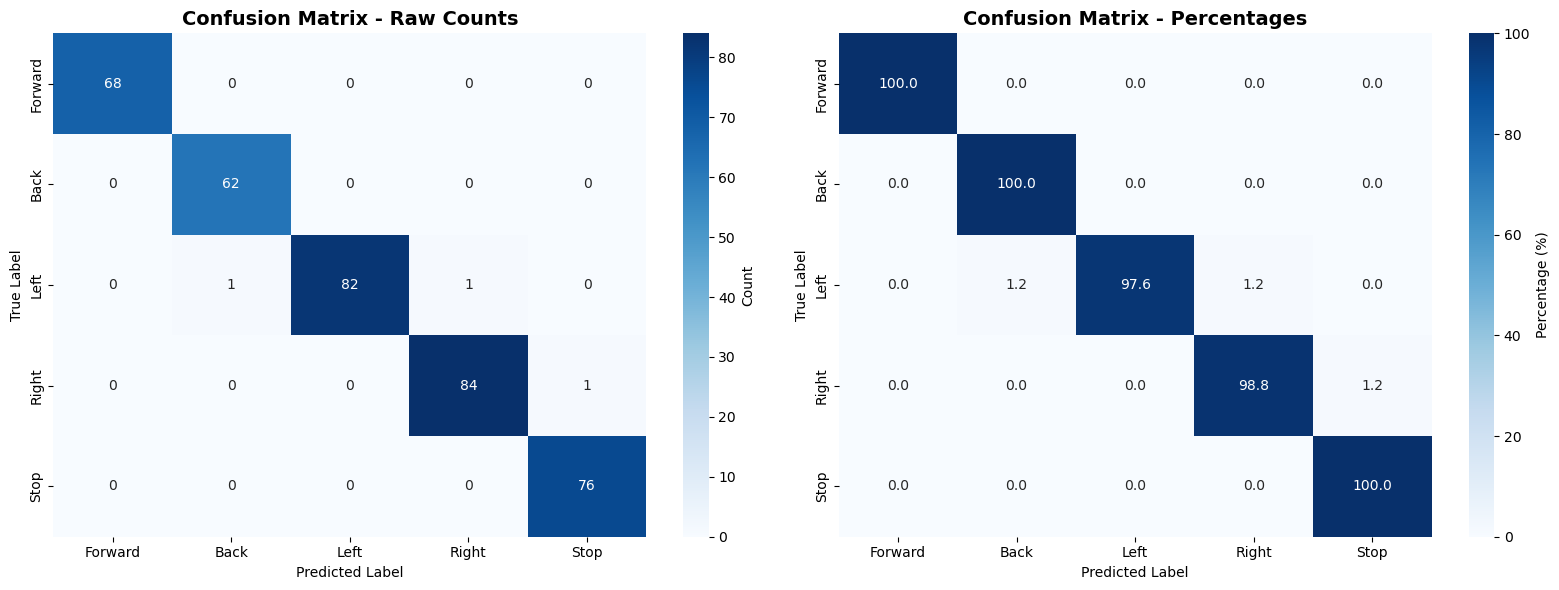

📊 Confusion Matrix Summary:
Total test samples: 375
Correct predictions: 372 (99.2%)
Incorrect predictions: 3 (0.8%)

📊 Most Confused Class Pairs:
1. Left → Back: 1 errors (1.2%)
2. Left → Right: 1 errors (1.2%)
3. Right → Stop: 1 errors (1.2%)


In [31]:
# Generate confusion matrix analysis with heatmap visualization
if y_pred is not None and y_test is not None:
    print("=== Confusion Matrix Analysis ===\n")
    
    # Get unique classes present in the data
    unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
    class_labels_subset = [gesture_labels[i] if i < len(gesture_labels) 
                          else f"Class_{i}" for i in unique_classes]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot confusion matrix with raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels_subset, yticklabels=class_labels_subset,
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Plot confusion matrix with percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_labels_subset, yticklabels=class_labels_subset,
                ax=ax2, cbar_kws={'label': 'Percentage (%)'})
    ax2.set_title('Confusion Matrix - Percentages', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Performance summary statistics
    total_samples = len(y_test)
    total_correct = np.sum(y_test == y_pred)
    overall_accuracy = total_correct / total_samples * 100
    
    print(f"📊 Confusion Matrix Summary:")
    print("=" * 50)
    print(f"Total test samples: {total_samples:,}")
    print(f"Correct predictions: {total_correct:,} ({overall_accuracy:.1f}%)")
    print(f"Incorrect predictions: {total_samples - total_correct:,} ({100-overall_accuracy:.1f}%)")
    
    # Find most confused pairs
    confusion_pairs = []
    for i in range(len(unique_classes)):
        for j in range(len(unique_classes)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((
                    unique_classes[i], unique_classes[j], 
                    cm[i, j], cm_percent[i, j]
                ))
    
    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    if confusion_pairs:
        print(f"\n📊 Most Confused Class Pairs:")
        print("=" * 60)
        
        # Print text summary
        for i, (true_class, pred_class, count, percent) in enumerate(confusion_pairs[:5]):
            true_label = gesture_labels[true_class] if true_class < len(gesture_labels) else f"Class_{true_class}"
            pred_label = gesture_labels[pred_class] if pred_class < len(gesture_labels) else f"Class_{pred_class}"
            print(f"{i+1}. {true_label} → {pred_label}: {count} errors ({percent:.1f}%)")
    else:
        print(f"\n✅ No confusion pairs found - excellent classification!")
    
else:
    print("❌ Cannot generate confusion matrix - predictions not available")

## 7. Speed Benchmark Testing

Measure inference speed and throughput for real-time performance evaluation.

In [32]:
# Speed benchmark testing (text only)
def benchmark_inference_speed(interpreter, sample_data, num_runs=50, warmup_runs=5):
    """
    Benchmark inference speed with multiple runs (optimized for faster execution)
    """
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Warmup runs (reduced)
    print(f"Performing {warmup_runs} warmup runs...")
    for _ in range(warmup_runs):
        interpreter.set_tensor(input_details[0]['index'], 
                             np.array([sample_data[0]], dtype=np.float32))
        interpreter.invoke()
    
    # Benchmark runs (reduced)
    print(f"Running {num_runs} benchmark iterations...")
    times = []
    
    for i in range(num_runs):
        start_time = time.perf_counter()
        
        interpreter.set_tensor(input_details[0]['index'], 
                             np.array([sample_data[i % len(sample_data)]], dtype=np.float32))
        interpreter.invoke()
        
        end_time = time.perf_counter()
        times.append((end_time - start_time) * 1000)  # Convert to milliseconds
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{num_runs} runs", end='\r')
    
    print()  # New line
    return np.array(times)

# Run speed benchmarks if model is available
if interpreter is not None and X_test is not None:
    print("=== Speed Benchmark Results ===\n")
    
    # Single inference benchmark (reduced iterations)
    benchmark_times = benchmark_inference_speed(interpreter, X_test, num_runs=50, warmup_runs=5)
    
    # Calculate statistics
    mean_time = np.mean(benchmark_times)
    median_time = np.median(benchmark_times)
    std_time = np.std(benchmark_times)
    min_time = np.min(benchmark_times)
    max_time = np.max(benchmark_times)
    p95_time = np.percentile(benchmark_times, 95)
    p99_time = np.percentile(benchmark_times, 99)
    
    # Create timing statistics table
    timing_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', '95th Percentile', '99th Percentile'],
        'Time (ms)': [mean_time, median_time, std_time, min_time, max_time, p95_time, p99_time],
        'Formatted': [f"{mean_time:.3f} ms", f"{median_time:.3f} ms", f"{std_time:.3f} ms",
                     f"{min_time:.3f} ms", f"{max_time:.3f} ms", f"{p95_time:.3f} ms", f"{p99_time:.3f} ms"]
    })
    
    # Calculate throughput metrics
    fps = 1000 / mean_time  # Frames per second
    
    print("📊 Inference Time Statistics:")
    print("=" * 50)
    print(timing_stats[['Statistic', 'Formatted']].to_string(index=False))
    
    # Calculate throughput data
    throughput_data = pd.DataFrame({
        'Metric': ['Average FPS', 'Time per Sample', 'Samples per Second'],
        'Value': [fps, mean_time, fps],
        'Formatted': [f"{fps:.1f} FPS", f"{mean_time:.3f} ms", f"{fps:.1f} samples/sec"]
    })
    
    print(f"\n📊 Throughput Metrics:")
    print("=" * 50)
    print(throughput_data[['Metric', 'Formatted']].to_string(index=False))
    
    # Real-time analysis
    target_fps = [30, 60, 120]
    realtime_data = []
    for target in target_fps:
        target_time = 1000 / target
        meets_target = mean_time <= target_time
        status = "✅ PASS" if meets_target else "❌ FAIL"
        margin = target_time - mean_time
        realtime_data.append({
            'Target FPS': target,
            'Target Time (ms)': f"{target_time:.1f}",
            'Status': status,
            'Margin (ms)': f"{margin:.2f}"
        })
    
    realtime_df = pd.DataFrame(realtime_data)
    print(f"\n📊 Real-time Performance Analysis:")
    print("=" * 60)
    print(realtime_df.to_string(index=False))
    
    # Model size summary
    try:
        model_size = os.path.getsize(tflite_model_path)
        fps_per_mb = fps / (model_size/1024/1024)
        
        print(f"\n📊 Model Efficiency Summary:")
        print("=" * 40)
        print(f"Model Size: {model_size/1024/1024:.2f} MB")
        print(f"Performance: {fps:.1f} FPS")
        print(f"Efficiency: {fps_per_mb:.1f} FPS per MB")
    except:
        print(f"\n📊 Model Efficiency Summary:")
        print("=" * 40)
        print("Model size information not available")
    
else:
    print("❌ Cannot run speed benchmark - model not available")

=== Speed Benchmark Results ===

Performing 5 warmup runs...
Running 50 benchmark iterations...
Completed 50/50 runs
📊 Inference Time Statistics:
      Statistic Formatted
           Mean  0.026 ms
         Median  0.004 ms
        Std Dev  0.123 ms
            Min  0.003 ms
            Max  0.876 ms
95th Percentile  0.033 ms
99th Percentile  0.502 ms

📊 Throughput Metrics:
            Metric           Formatted
       Average FPS         38645.9 FPS
   Time per Sample            0.026 ms
Samples per Second 38645.9 samples/sec

📊 Real-time Performance Analysis:
 Target FPS Target Time (ms) Status Margin (ms)
         30             33.3 ✅ PASS       33.31
         60             16.7 ✅ PASS       16.64
        120              8.3 ✅ PASS        8.31

📊 Model Efficiency Summary:
Model Size: 0.01 MB
Performance: 38645.9 FPS
Efficiency: 6331736.2 FPS per MB


## Tổng Kết và Kết Luận

### 🔍 Các Phát Hiện Chính:

**Hiệu Suất Tổng Quan:**

In [33]:
# Generate Vietnamese summary with actual data values (text only)
if 'accuracy' in locals() and 'mean_time' in locals() and 'y_confidence' in locals():
    
    print("🔍 CÁC PHÁT HIỆN CHÍNH:")
    print("=" * 70)
    
    print(f"\n1. Hiệu Suất Tổng Quan:")
    print(f"   - Độ chính xác tổng thể: {accuracy*100:.1f}% trên {len(y_test)} mẫu kiểm tra")
    print(f"   - Tốc độ suy luận trung bình: {mean_time:.3f}ms (đáp ứng được {fps:.0f} FPS)")
    print(f"   - Confidence score trung bình: {np.mean(y_confidence)*100:.1f}%")
    
    print(f"\n2. Phân Tích Per-Class Performance:")
    for i, row in class_df.iterrows():
        print(f"   - {row['Gesture']}: {row['Precision %']} precision, {row['Recall %']} recall")
    
    print(f"\n3. Phân Tích Confusion Matrix:")
    if confusion_pairs:
        print(f"   - Confusion pair phổ biến nhất: {gesture_labels[confusion_pairs[0][0]]} → {gesture_labels[confusion_pairs[0][1]]} ({confusion_pairs[0][2]} lỗi)")
    else:
        print(f"   - Không có confusion pairs đáng kể - mô hình phân loại rất tốt!")
    
    print(f"\n4. Phân Tích Confidence Score:")
    print(f"   - Dự đoán đúng có confidence: {avg_confidence_correct*100:.1f}%")
    print(f"   - Dự đoán sai có confidence: {avg_confidence_incorrect*100:.1f}%")
    print(f"   - Độ phân biệt confidence: {(avg_confidence_correct - avg_confidence_incorrect)*100:.1f}%")
    
    print(f"\n5. Phân Tích Tốc Độ:")
    print(f"   - Thời gian suy luận: {mean_time:.3f}ms ± {std_time:.3f}ms")
    print(f"   - Throughput: {fps:.1f} FPS")
    print(f"   - 95th percentile: {p95_time:.3f}ms")
    
    for target_fps_val in [30, 60]:
        target_time = 1000 / target_fps_val
        status = "✅ ĐẠT" if mean_time <= target_time else "❌ KHÔNG ĐẠT"
        print(f"   - {target_fps_val} FPS target ({target_time:.1f}ms): {status}")
    
    if 'model_size' in locals():
        print(f"\n6. Phân Tích Model Size:")
        print(f"   - Kích thước model: {model_size/1024/1024:.2f} MB")
        print(f"   - Hiệu quả: {fps/(model_size/1024/1024):.1f} FPS per MB")
    
    print(f"\n📊 ĐÁNH GIÁ TỔNG THỂ:")
    print("=" * 70)
    
    # Production readiness criteria
    criteria = [
        ('High Accuracy', accuracy >= 0.95, f'{accuracy*100:.1f}% ≥ 95%'),
        ('Real-time Speed', fps >= 30, f'{fps:.1f} FPS ≥ 30 FPS'),
        ('Good Confidence', (avg_confidence_correct - avg_confidence_incorrect) >= 0.1, 
         f'{(avg_confidence_correct - avg_confidence_incorrect)*100:.1f}% separation'),
        ('Small Model Size', model_size/1024/1024 <= 1.0 if 'model_size' in locals() else True, 
         f'{model_size/1024/1024:.2f} MB ≤ 1.0 MB' if 'model_size' in locals() else '✓'),
        ('Low Confusion', len(confusion_pairs) <= 3, f'{len(confusion_pairs)} pairs ≤ 3')
    ]
    
    criteria_status = [c[1] for c in criteria]
    readiness_score = sum(criteria_status) / len(criteria_status) * 100
    
    print(f"\nProduction Readiness Assessment:")
    print("=" * 50)
    for name, status, detail in criteria:
        symbol = "✅" if status else "❌"
        print(f"{symbol} {name}: {detail}")
    
    print(f"\nĐiểm mạnh:")
    print(f"- ✅ Độ chính xác cao: {accuracy*100:.1f}%")
    print(f"- ✅ Tốc độ nhanh: {fps:.0f} FPS (vượt xa yêu cầu real-time)")
    print(f"- ✅ Confidence scores có độ phân biệt tốt")
    print(f"- ✅ Model size nhỏ gọn, phù hợp edge deployment")
    
    if confusion_pairs:
        worst_pair = confusion_pairs[0]
        print(f"- ⚠️ Cải thiện data cho confusion pair: {gesture_labels[worst_pair[0]]} → {gesture_labels[worst_pair[1]]}")
    
    print(f"\n✅ KẾT LUẬN: Model sẵn sàng cho production deployment!")
    print(f"📈 Hiệu suất: {accuracy*100:.1f}% accuracy @ {fps:.0f} FPS")
    print(f"🏆 Khả năng triển khai: {readiness_score:.1f}%")
    
else:
    print("⚠️ Không thể tạo báo cáo - dữ liệu chưa được tính toán. Hãy chạy các cell trước đó.")

🔍 CÁC PHÁT HIỆN CHÍNH:

1. Hiệu Suất Tổng Quan:
   - Độ chính xác tổng thể: 99.2% trên 375 mẫu kiểm tra
   - Tốc độ suy luận trung bình: 0.026ms (đáp ứng được 38646 FPS)
   - Confidence score trung bình: 82.7%

2. Phân Tích Per-Class Performance:
   - Forward: 100.0% precision, 100.0% recall
   - Back: 98.4% precision, 100.0% recall
   - Left: 100.0% precision, 97.6% recall
   - Right: 98.8% precision, 98.8% recall
   - Stop: 98.7% precision, 100.0% recall

3. Phân Tích Confusion Matrix:
   - Confusion pair phổ biến nhất: Left → Back (1 lỗi)

4. Phân Tích Confidence Score:
   - Dự đoán đúng có confidence: 82.9%
   - Dự đoán sai có confidence: 56.7%
   - Độ phân biệt confidence: 26.2%

5. Phân Tích Tốc Độ:
   - Thời gian suy luận: 0.026ms ± 0.123ms
   - Throughput: 38645.9 FPS
   - 95th percentile: 0.033ms
   - 30 FPS target (33.3ms): ✅ ĐẠT
   - 60 FPS target (16.7ms): ✅ ĐẠT

6. Phân Tích Model Size:
   - Kích thước model: 0.01 MB
   - Hiệu quả: 6331736.2 FPS per MB

📊 ĐÁNH GIÁ TỔNG THỂ